In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from uszipcode import SearchEngine
from IPython.display import Image
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.distance import distance
import math
import csv

# Import Data

In [33]:
df = pd.read_csv('./Data/df_all_features_county.csv')
# Desired prediction var
predict_label = ['PHEV', 'BEV']

# Drop zip code since it would increase the number of features by ~4k
# also zip code is highly correlated to population and income
# Drop registration date since we will change to Unix timestamps
drop_col = ['state','County', 'Registration Date', 'fips', 'Unix Time']

# Get labels of all features
features = [c for c in df.columns if c not in predict_label + drop_col]
features

print(features)
df.head()

['Average EV Price', 'New Car Average', 'population', 'household_income', 'POPDEN_COU', 'Electricity Price', 'Gas Price', 'NY', 'TX', 'WA']


,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2017-01-01,Adams County,22.0,54669.0,38747.0,509844.0,167290.0,CO,445.323695,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8001,24.0
1,2017-01-01,Arapahoe County,61.0,54669.0,38747.0,649980.0,241889.0,CO,821.038725,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8005,65.0
2,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8013,167.0
3,2017-01-01,Broomfield County,7.0,54669.0,38747.0,69444.0,27199.0,CO,2248.011733,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8014,14.0
4,2017-01-01,Denver County,56.0,54669.0,38747.0,715878.0,287756.0,CO,4674.337363,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8031,94.0


In [34]:
df_a = pd.read_csv('./Data/df_adjacency.csv')
df_a.head()

,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi),Coordinates,county_lat,county_lon
0,"Adams County, CO",8001,"Adams County, CO",8001,Adams County,CO,Adams County,CO,1,0.000000,"(39.8714085, -104.2701374)",39.871409,-104.270137
1,"Adams County, CO",8001,"Arapahoe County, CO",8005,Adams County,CO,Arapahoe County,CO,1,16.600485,"(39.8714085, -104.2701374)",39.871409,-104.270137
2,"Adams County, CO",8001,"Broomfield County, CO",8014,Adams County,CO,Broomfield County,CO,1,683.581802,"(39.8714085, -104.2701374)",39.871409,-104.270137
3,"Adams County, CO",8001,"Denver County, CO",8031,Adams County,CO,Denver County,CO,1,649.967579,"(39.8714085, -104.2701374)",39.871409,-104.270137
4,"Adams County, CO",8001,"Jefferson County, CO",8059,Adams County,CO,Jefferson County,CO,1,56.499723,"(39.8714085, -104.2701374)",39.871409,-104.270137


# Verify Adjacency Geocode

In [35]:
# Assuming you have a DataFrame called 'df'
random_rows = df_a.sample(n=5)
random_rows

,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi),Coordinates,county_lat,county_lon
796,"Sullivan County, NY",36105,"Orange County, NY",36071,Sullivan County,NY,Orange County,NY,1,35.600453,"(41.7156311, -74.7804323)",41.715631,-74.780432
2565,"Wichita County, TX",48485,"Wilbarger County, TX",48487,Wichita County,TX,Wilbarger County,TX,1,29.149769,"(33.9516534, -98.7088886)",33.951653,-98.708889
1797,"Kimble County, TX",48267,"Kerr County, TX",48265,Kimble County,TX,Kerr County,TX,1,39.214270,"(30.4744131, -99.8199792)",30.474413,-99.819979
1316,"Duval County, TX",48131,"Jim Hogg County, TX",48247,Duval County,TX,Jim Hogg County,TX,1,47.248394,"(27.6708701, -98.5121975)",27.670870,-98.512197
1546,"Hansford County, TX",48195,"Sherman County, TX",48421,Hansford County,TX,Sherman County,TX,1,29.258385,"(36.2563401, -101.3621472)",36.256340,-101.362147


In [36]:
geolocator = Nominatim(user_agent='my_app')
coordinates = []
for c in random_rows['countyname']:
    county = geolocator.geocode(c + ', USA')
    coordinates.append((county.latitude, county.longitude))

print(coordinates)

[(41.7156311, -74.7804323), (33.9516534, -98.7088886), (30.4744131, -99.8199792), (27.6708701, -98.5121975), (36.2563401, -101.3621472)]


In [37]:
c = 'Coleman County, TX'
county = geolocator.geocode(c + ', USA')
print((county.latitude, county.longitude))

(31.7766863, -99.4461098)


Looks like the coordinates were extracted correctly. Now check distance.

In [38]:
# Define a function to calculate distance between two counties
def calculate_distance(row):
    # Look up latitude and longitude coordinates for county and neighbor
    county = geolocator.geocode(row['countyname'] + ', USA')
    neighbor = geolocator.geocode(row['neighborname'] + ', USA')
    # Calculate distance using Haversine formula
    try:
        dist = geodesic((county.latitude, county.longitude), (neighbor.latitude, neighbor.longitude)).miles
    except:
        dist = 0
    return dist

def calculate_distance_2(row):
    # Look up latitude and longitude coordinates for county and neighbor
    county = geolocator.geocode(row['countyname'] + ', USA')
    neighbor = geolocator.geocode(row['neighborname'] + ', USA')
    # Calculate distance using Haversine formula
    try:
        dist = distance((county.latitude, county.longitude), (neighbor.latitude, neighbor.longitude)).miles
    except:
        dist = 0
    return dist

def calculate_distance_3(row):
    """
    Calculate the distance between two points on the Earth's surface
    using latitude and longitude coordinates.
    """
    # Look up latitude and longitude coordinates for county and neighbor
    county = geolocator.geocode(row['countyname'] + ', USA')
    neighbor = geolocator.geocode(row['neighborname'] + ', USA')

    # Earth's radius in miles
    earth_radius_miles = 3958.8

    # Calculate distance using Haversine formula
    try:
        lat1 = county.latitude
        lon1 = county.longitude
        lat2 = neighbor.latitude
        lon2 = neighbor.longitude
        
        # Convert degrees to radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        # Haversine formula
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        # Calculate distance in miles
        dist = earth_radius_miles * c
        
        
    except:
        dist = 0


    return dist


random_rows['distance_test'] = random_rows.apply(calculate_distance, axis=1)
random_rows['dist_test_2'] = random_rows.apply(calculate_distance_2, axis=1)
random_rows['dist_test_3'] = random_rows.apply(calculate_distance_3, axis=1)
random_rows

,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi),Coordinates,county_lat,county_lon,distance_test,dist_test_2,dist_test_3
796,"Sullivan County, NY",36105,"Orange County, NY",36071,Sullivan County,NY,Orange County,NY,1,35.600453,"(41.7156311, -74.7804323)",41.715631,-74.780432,35.600453,35.600453,35.562952
2565,"Wichita County, TX",48485,"Wilbarger County, TX",48487,Wichita County,TX,Wilbarger County,TX,1,29.149769,"(33.9516534, -98.7088886)",33.951653,-98.708889,29.149769,29.149769,29.091233
1797,"Kimble County, TX",48267,"Kerr County, TX",48265,Kimble County,TX,Kerr County,TX,1,39.214270,"(30.4744131, -99.8199792)",30.474413,-99.819979,39.214270,39.214270,39.249230
1316,"Duval County, TX",48131,"Jim Hogg County, TX",48247,Duval County,TX,Jim Hogg County,TX,1,47.248394,"(27.6708701, -98.5121975)",27.670870,-98.512197,47.248394,47.248394,47.397825
1546,"Hansford County, TX",48195,"Sherman County, TX",48421,Hansford County,TX,Sherman County,TX,1,29.258385,"(36.2563401, -101.3621472)",36.256340,-101.362147,29.258385,29.258385,29.191833


Looks like the distances were calculated correctly. Now check manually with google maps

Looks like distances are also calculated correctly

# Sample Small Graph
Use Dallas County and surrounding neighbors

In [39]:
county_sample = ['Dallas County',
                'Tarrant County',
                'Rockwall County',
                'Kaufman County',
                'Collin County',
                'Denton County',
                'Ellis County',
                'Grayson County',
                'Fannin County',
                'Wise County']

month = '2021-04-01'

In [40]:
# extract based on county cample and month
df_s = df[(df['County'].isin(county_sample)) & (df['TX'] == 1) & (df['Registration Date'] == month)]

df_s

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
5591,2021-04-01,Collin County,1855.0,56059.0,41172.0,1006038.0,353491.0,TX,1265.337605,0.14,2.150,0.0,1.0,0.0,1.617235e+09,48085,4775.0
5595,2021-04-01,Dallas County,3047.0,56059.0,41172.0,2622634.0,945996.0,TX,2993.573686,0.14,2.150,0.0,1.0,0.0,1.617235e+09,48113,7053.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,2021-04-01,Tarrant County,1975.0,56059.0,41172.0,2077153.0,722446.0,TX,2439.255609,0.14,2.150,0.0,1.0,0.0,1.617235e+09,48439,5046.0
5664,2021-04-01,Wise County,39.0,56059.0,41172.0,67884.0,22254.0,TX,75.887723,10.77,2.551,0.0,1.0,0.0,1.617235e+09,48497,62.0


# State of TX
Overwrite sample df to explore the entire state of TX

In [55]:
df_s = df[(df['TX'] == 1) & (df['Registration Date'] == month)]

df_s

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
5575,2021-04-01,Angelina County,43.0,56059.0,41172.0,87119.0,31368.0,TX,108.283338,10.77,2.551,0.0,1.0,0.0,1.617235e+09,48005,33.0
5576,2021-04-01,Aransas County,18.0,56059.0,41172.0,24220.0,9917.0,TX,94.537981,10.77,2.551,0.0,1.0,0.0,1.617235e+09,48007,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10776,2021-04-01,Val Verde County,0.0,56059.0,41172.0,49018.0,16388.0,TX,15.131973,10.77,2.551,0.0,1.0,0.0,1.617235e+09,48465,37.0
10777,2021-04-01,Washington County,0.0,56059.0,41172.0,35275.0,13321.0,TX,59.261091,10.77,2.551,0.0,1.0,0.0,1.617235e+09,48477,12.0


# Visualize Connectivity

In [56]:
# extract only county, fips, lat/lon for unique values
df_fips = df_a[['countyname','fipscounty', 'county_lat','county_lon']].drop_duplicates()

# check if numbers are the same, should be
print(len(df_fips['fipscounty'].unique()))
print(len(df_fips))

419
419


In [57]:
# create a mapping for fips to coordinates
fips_coord_map = {fips: (lat, lon) for fips, lat, lon in zip(df_fips['fipscounty'], df_fips['county_lat'], df_fips['county_lon'])}
print(len(fips_coord_map))
fips_coord_map

419


{8001: (39.8714085, -104.2701374),
 8003: (37.5780995, -105.7890452),
 8005: (39.6416781, -104.3628567),
 8007: (37.1995993, -107.0842479),
 8009: (37.3147687, -102.5770885),
 8011: (37.9421152, -103.0964287),
 8013: (40.102555, -105.3632079),
 8014: (35.4764701, -93.0785067),
 8015: (38.7413025, -106.1825012),
 8017: (38.8307233, -102.6177692),
 8019: (39.6754591, -105.6435349),
 8021: (37.1851939, -106.1655431),
 8023: (37.2367948, -105.4182008),
 8025: (38.3394806, -103.8263042),
 8027: (38.1072962, -105.3543375),
 8029: (38.8368777, -107.8568294),
 8031: (42.6713752, -92.3372158),
 8033: (37.7524811, -108.4596087),
 8035: (39.3420437, -104.9468945),
 8037: (39.6161124, -106.7172844),
 8039: (39.3138822, -104.0868973),
 8041: (38.8287435, -104.5253456),
 8043: (38.4692006, -105.4328622),
 8045: (39.5462048, -107.8776144),
 8047: (39.8586654, -105.5025219),
 8049: (40.0990074, -106.1366966),
 8051: (38.6476702, -107.0603126),
 8053: (37.813681, -107.3304179),
 8055: (37.7013983, -105

In [58]:
# extract fips only from our sample to map them into lat/lon coord
fips_sample = df_s['fips']
fips_sample

5575     48005
5576     48007
         ...  
10776    48465
10777    48477
Name: fips, Length: 150, dtype: int64

In [59]:
fips_idx_map = dict(zip(fips_sample, range(len(fips_sample))))
fips_idx_map

{48005: 0,
 48007: 1,
 48021: 2,
 48027: 3,
 48029: 4,
 48031: 5,
 48035: 6,
 48037: 7,
 48039: 8,
 48041: 9,
 48053: 10,
 48055: 11,
 48061: 12,
 48067: 13,
 48071: 14,
 48073: 15,
 48085: 16,
 48091: 17,
 48097: 18,
 48099: 19,
 48113: 20,
 48121: 21,
 48135: 22,
 48141: 23,
 48139: 24,
 48143: 25,
 48147: 26,
 48157: 27,
 48167: 28,
 48171: 29,
 48177: 30,
 48181: 31,
 48183: 32,
 48185: 33,
 48187: 34,
 48193: 35,
 48199: 36,
 48201: 37,
 48203: 38,
 48209: 39,
 48213: 40,
 48215: 41,
 48217: 42,
 48221: 43,
 48231: 44,
 48233: 45,
 48245: 46,
 48251: 47,
 48257: 48,
 48259: 49,
 48265: 50,
 48273: 51,
 48277: 52,
 48285: 53,
 48291: 54,
 48299: 55,
 48303: 56,
 48315: 57,
 48323: 58,
 48309: 59,
 48325: 60,
 48329: 61,
 48339: 62,
 48347: 63,
 48349: 64,
 48355: 65,
 48363: 66,
 48367: 67,
 48375: 68,
 48381: 69,
 48397: 70,
 48409: 71,
 48423: 72,
 48427: 73,
 48439: 74,
 48441: 75,
 48449: 76,
 48451: 77,
 48453: 78,
 48455: 79,
 48463: 80,
 48467: 81,
 48469: 82,
 48471: 83,
 4

In [60]:
# only take out adjacency attributes if the fips list of month df
df_e = df_a[(df_a['fipscounty'].isin(fips_sample)) & (df_a['fipsneighbor'].isin(fips_sample))]

df_e.reset_index(inplace=True)

df_e

,index,countyname,fipscounty,neighborname,fipsneighbor,county,state,neighbor_county,neighbor_state,count,distance_(mi),Coordinates,county_lat,county_lon
0,858,"Anderson County, TX",48001,"Anderson County, TX",48001,Anderson County,TX,Anderson County,TX,1,0.000000,"(31.7819242, -95.6258199)",31.781924,-95.625820
1,859,"Anderson County, TX",48001,"Cherokee County, TX",48073,Anderson County,TX,Cherokee County,TX,1,26.571550,"(31.7819242, -95.6258199)",31.781924,-95.625820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,2627,"Zapata County, TX",48505,"Webb County, TX",48479,Zapata County,TX,Webb County,TX,1,49.191909,"(26.9879626, -99.1673556)",26.987963,-99.167356
729,2628,"Zapata County, TX",48505,"Zapata County, TX",48505,Zapata County,TX,Zapata County,TX,1,0.000000,"(26.9879626, -99.1673556)",26.987963,-99.167356


In [61]:
start = [fips_idx_map[x] for x in df_e['fipscounty']]
end = [fips_idx_map[x] for x in df_e['fipsneighbor']] 
activated_arcs = list(zip(start,end))
activated_arcs = [x for x in activated_arcs if x[0] != x[1]]
activated_arcs

[(92, 15),
 (92, 104),
 (92, 40),
 (0, 15),
 (0, 133),
 (0, 63),
 (0, 141),
 (0, 79),
 (1, 65),
 (1, 71),
 (123, 4),
 (123, 136),
 (123, 60),
 (123, 88),
 (2, 11),
 (2, 128),
 (2, 109),
 (2, 78),
 (2, 87),
 (93, 136),
 (93, 71),
 (3, 10),
 (3, 19),
 (3, 108),
 (3, 59),
 (3, 113),
 (3, 87),
 (4, 123),
 (4, 17),
 (4, 34),
 (4, 49),
 (4, 60),
 (4, 88),
 (5, 10),
 (5, 17),
 (5, 29),
 (5, 39),
 (5, 49),
 (5, 55),
 (5, 78),
 (6, 19),
 (6, 25),
 (6, 35),
 (6, 42),
 (6, 47),
 (6, 59),
 (6, 145),
 (7, 13),
 (7, 114),
 (8, 27),
 (8, 28),
 (8, 37),
 (8, 111),
 (8, 122),
 (9, 33),
 (9, 149),
 (94, 134),
 (94, 117),
 (95, 96),
 (95, 126),
 (95, 97),
 (95, 102),
 (95, 138),
 (10, 3),
 (10, 5),
 (10, 108),
 (10, 55),
 (10, 78),
 (10, 87),
 (11, 2),
 (11, 128),
 (11, 30),
 (11, 34),
 (11, 39),
 (11, 78),
 (96, 95),
 (96, 126),
 (96, 102),
 (96, 75),
 (12, 41),
 (124, 103),
 (124, 114),
 (124, 76),
 (124, 147),
 (124, 90),
 (13, 7),
 (13, 57),
 (13, 114),
 (14, 28),
 (14, 37),
 (14, 46),
 (14, 54),
 (1

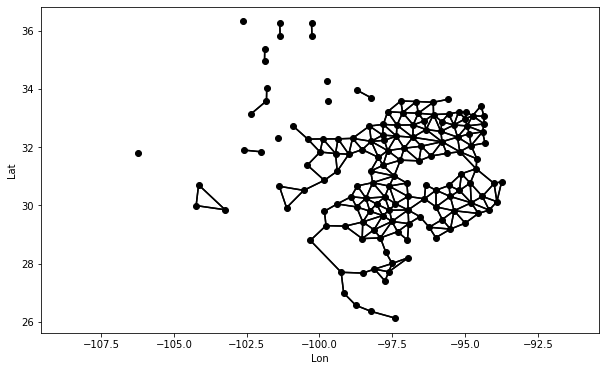

In [63]:
# create a new figure with a bigger size
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

lat_coords = [fips_coord_map[x][0] for x in fips_sample]
lon_coords = [fips_coord_map[x][1] for x in fips_sample]

labels = df_s['County'].to_list()
labels = [x.split()[0] for x in labels]

# plot the points
ax.scatter(lon_coords, lat_coords, color='black')

# for i in range(len(lat_coords)):
#     #ax.scatter(lon_coords[i], lat_coords[i], color=colors[i])
#     ax.annotate(labels[i], xy=(lon_coords[i], lat_coords[i]), xytext=(lon_coords[i]+0.001, lat_coords[i]+0.001))


# plot the lines between the connected nodes
for connection in activated_arcs:
    x1, y1 = lon_coords[connection[0]], lat_coords[connection[0]]
    x2, y2 = lon_coords[connection[1]], lat_coords[connection[1]]

    # Plot the line between (x1, y1) and (x2, y2)
    ax.plot([x1, x2], [y1, y2], color='black')
    
# set the axis limits and labels
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.axis('equal')

# display the plot
plt.show()

# Assemble GNN Matrices

In [64]:
# store features for each node, n_node x n_features
df_X_gnn = df_s[features]
df_X_gnn.to_csv('./Data/df_X_gnn.csv', index = False)
df_X_gnn

,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA
5575,56059.0,41172.0,87119.0,31368.0,108.283338,10.77,2.551,0.0,1.0,0.0
5576,56059.0,41172.0,24220.0,9917.0,94.537981,10.77,2.551,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
10776,56059.0,41172.0,49018.0,16388.0,15.131973,10.77,2.551,0.0,1.0,0.0
10777,56059.0,41172.0,35275.0,13321.0,59.261091,10.77,2.551,0.0,1.0,0.0


In [65]:
# output values to be predicted at each node, n_node x n_pred
df_y_gnn = df_s['PHEV']
df_y_gnn.to_csv('./Data/df_y_gnn.csv', index = False)
df_y_gnn

5575     43.0
5576     18.0
         ... 
10776     0.0
10777     0.0
Name: PHEV, Length: 150, dtype: float64

In [66]:
# transpose activated arcs to get in correct shape for gnn
activated_arcs = np.array(activated_arcs)

# Define the output file path
output_file = './Data/df_e_idx_gnn.csv'

# Export the NumPy array to a CSV file
np.savetxt(output_file, activated_arcs.T, delimiter=',')
